# 🏥 Early Sepsis Detection using SBRE

# Stakeholder Walkthrough (Plain English)

This notebook simulates an **early sepsis detection system** using synthetic ICU data.
Each step is designed so non-technical stakeholders can follow the story.

---

### 1. Data Upload
We start by uploading two ICU datasets:
- **Cohort file**: one row per patient (demographics, comorbidities, outcomes).
- **Time-series file**: hourly vital signs, lab results, interventions.

---

### 2. Load & Validate Data
We check that:
- All expected columns exist.
- Patient IDs match across files.
- There are no duplicates or inconsistencies.

---

### 3. Cohort Snapshot (Who’s in our ICU?)
We describe the population:
- Number of patients.
- Age distribution.
- Sepsis prevalence (how many develop sepsis).
- Mortality in septic vs. non-septic patients.

---

### 4. Time-Series Sanity Checks
We verify the quality of the hourly ICU data:
- How many hours per patient are recorded.
- Amount of missing data.
- Frequency of sepsis flags over time.

---

### 5. Scenario Mapping (SBRE)
We identify **four representative patient “stories”**:
- **Standard**: stable patient, no sepsis.
- **Complex**: subtle early warning signs before sepsis.
- **Failure**: sudden rapid deterioration.
- **Exception**: unusual case with missing or inconsistent data.

---

### 6. Feature Engineering (Preparing Signals)
We prepare model-friendly inputs by:
- Filling in missing values.
- Calculating rolling averages and short-term changes (6h windows).
- Creating early-warning labels: “Will this patient develop sepsis in the next 6 hours?”

---

### 7. Model Training (Early Sepsis Detector)
We train a **Random Forest model** on patient data.
It outputs a probability (0–1) that the patient will become septic soon.

---

### 8. Model Evaluation
We test the model on unseen patients and measure:
- **AUROC/AUPRC** → how well it distinguishes septic vs. non-septic.
- **Precision/Recall** → balance between catching cases and avoiding false alarms.
- **Lead time** → how many hours before sepsis the first alert is raised.

---

### 9. Threshold Selection (Policy Choices)
We try two modes:
- **Recall-focused**: catch more cases early (more alerts).
- **Precision-focused**: fewer false alarms (but may miss some cases).

This mirrors real-world hospital trade-offs: safety vs. alarm fatigue.

---

### 10. Scenario Narratives
For each scenario (Standard, Complex, Failure, Exception), we show:
- Vitals and lab trends.
- When alerts are triggered.
- Lead time before onset.
- System’s recommended actions: monitor, early warning, escalate, or check data quality.

---

### 11. Alarm-Fatigue Analysis
We measure how many alerts occur per 24 hours across patients.
This checks if the alert burden is reasonable for clinical staff.

---

### 12. Horizon Comparison
We compare prediction windows:
- **3h, 6h, 12h horizons**.
Shorter horizons = higher precision.
Longer horizons = more recall (but more alerts).

---

### 13. Exporting Outputs
We generate stakeholder-ready artifacts:
- **JSON/NDJSON** files with scenario responses.
- **PDF/CSV** summaries of metrics and scenarios.
- Graphs (ROC, PR, patient timelines).

These outputs are used in presentations, reports, and demos.

---

In [13]:
# Upload sepsis_cohort.csv and sepsis_timeseries.csv
from google.colab import files
uploaded = files.upload()  # choose the two CSVs

Saving data_dictionary.yaml to data_dictionary (1).yaml
Saving sepsis_timeseries.csv to sepsis_timeseries (1).csv
Saving sepsis_cohort.csv to sepsis_cohort (1).csv


In [14]:
import pandas as pd
import numpy as np

# If you used Option A:
COHORT_PATH = COHORT_PATH if 'COHORT_PATH' in globals() else "sepsis_cohort.csv"
TS_PATH     = TS_PATH     if 'TS_PATH'     in globals() else "sepsis_timeseries.csv"

Step 1 — Load & Validate

In [15]:
cohort = pd.read_csv(COHORT_PATH)
ts = pd.read_csv(TS_PATH)

print("cohort shape:", cohort.shape)
print("timeseries shape:", ts.shape)

expected_cohort_cols = {
    'patient_id','age','sex','height_cm','weight_kg','ethnicity','icu_unit','admission_type',
    'has_diabetes2','has_hypertension','has_ckd','has_copd','has_immunosuppression',
    'length_of_stay_hours','sepsis_label','sepsis_onset_hour','mortality_in_hosp'
}
expected_ts_cols = {
    'patient_id','hour','HR','SBP','DBP','MAP','RR','Temp_C','SpO2','GCS','WBC','Platelets',
    'Lactate','Creatinine','Bilirubin','FiO2','PaO2','PaO2_FiO2','UrineOutput_ml',
    'vasopressor','mech_vent','antibiotics','qSOFA','SOFA','sepsis_label_hourly'
}

missing_cohort = expected_cohort_cols - set(cohort.columns)
missing_ts = expected_ts_cols - set(ts.columns)
print("Missing in cohort:", missing_cohort)
print("Missing in timeseries:", missing_ts)

cohort shape: (500, 17)
timeseries shape: (21726, 25)
Missing in cohort: set()
Missing in timeseries: set()


In [16]:
# Basic dtypes sanity
display(cohort.head())
display(ts.head())


,patient_id,age,sex,height_cm,weight_kg,ethnicity,icu_unit,admission_type,has_diabetes2,has_hypertension,has_ckd,has_copd,has_immunosuppression,length_of_stay_hours,sepsis_label,sepsis_onset_hour,mortality_in_hosp
0,P100000,86,F,155,75.4,Hispanic/Latino,Mixed ICU,Emergency,0,0,0,0,0,98,0,NaN,0
1,P100001,64,M,172,84.9,White,Mixed ICU,Urgent,0,1,0,0,0,111,0,NaN,1
2,P100002,72,F,177,93.9,White,Neuro ICU,Emergency,1,0,0,0,1,38,1,11.0,0
3,P100003,61,F,174,98.9,Black,SICU,Emergency,0,1,0,0,0,73,0,NaN,0
4,P100004,59,M,176,71.7,White,SICU,Elective,0,0,0,0,0,22,0,NaN,0


,patient_id,hour,HR,SBP,DBP,MAP,RR,Temp_C,SpO2,GCS,...,FiO2,PaO2,PaO2_FiO2,UrineOutput_ml,vasopressor,mech_vent,antibiotics,qSOFA,SOFA,sepsis_label_hourly
0,P100000,0,78.430249,100.218090,35.000000,73.547990,16.709399,36.172183,93.1,NaN,...,0.21,91.6,436.2,36.0,0,0,0,1,1,0
1,P100000,1,91.186080,119.856831,48.544964,74.664209,20.716258,36.758857,93.7,14.5,...,0.21,100.4,477.9,7.0,0,0,0,1,1,0
2,P100000,2,78.485569,108.806547,38.354391,74.855257,17.525491,36.006210,96.1,15.0,...,0.50,NaN,192.6,7.0,0,0,0,0,3,0
3,P100000,3,74.031476,118.840035,48.974009,76.613174,19.450809,36.274724,95.4,15.0,...,0.21,NaN,NaN,16.0,0,0,0,0,0,0
4,P100000,4,80.080383,109.740556,38.646608,75.065170,20.036567,36.524953,93.1,NaN,...,0.21,81.7,389.2,14.0,0,0,0,1,2,0


In [17]:
# Ensure key integrity
assert cohort['patient_id'].is_unique, "patient_id must be unique in cohort"
assert not ts[['patient_id','hour']].duplicated().any(), "Duplicate patient_id-hour rows in timeseries"
assert set(ts['patient_id']).issubset(set(cohort['patient_id'])), "Timeseries has patient_ids not in cohort"

Step 2 — Cohort Snapshot (who’s in our ICU?)

In [18]:
import numpy as np

n_patients = len(cohort)
prev = cohort['sepsis_label'].mean()
mort_all = cohort['mortality_in_hosp'].mean()
mort_by_sepsis = cohort.groupby('sepsis_label')['mortality_in_hosp'].mean().rename({0:'non-septic',1:'septic'})

summary = {
    "patients": n_patients,
    "sepsis_prevalence_%": round(prev*100, 2),
    "mortality_overall_%": round(mort_all*100, 2),
    "mortality_nonseptic_%": round(mort_by_sepsis.get(0, np.nan)*100, 2),
    "mortality_septic_%": round(mort_by_sepsis.get(1, np.nan)*100, 2),
    "age_mean": round(cohort['age'].mean(), 1),
    "age_std": round(cohort['age'].std(), 1),
    "los_hours_mean": round(cohort['length_of_stay_hours'].mean(), 1),
}
summary

/tmp/ipython-input-502035412.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "mortality_nonseptic_%": round(mort_by_sepsis.get(0, np.nan)*100, 2),
/tmp/ipython-input-502035412.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "mortality_septic_%": round(mort_by_sepsis.get(1, np.nan)*100, 2),


{'patients': 500,
 'sepsis_prevalence_%': np.float64(15.2),
 'mortality_overall_%': np.float64(6.6),
 'mortality_nonseptic_%': np.float64(5.66),
 'mortality_septic_%': np.float64(11.84),
 'age_mean': np.float64(60.7),
 'age_std': 16.6,
 'los_hours_mean': np.float64(72.7)}

In [19]:
# Categorical distributions
cat_cols = ['sex','icu_unit','admission_type','ethnicity']
for c in cat_cols:
    print(f"\n=== {c} ===")
    print(cohort[c].value_counts(dropna=False).to_string())

# Comorbidities prevalence
comorb_cols = ['has_diabetes2','has_hypertension','has_ckd','has_copd','has_immunosuppression']
(comorb := cohort[comorb_cols].mean().sort_values(ascending=False)*100).round(1)


=== sex ===
sex
M    275
F    225

=== icu_unit ===
icu_unit
MICU         218
SICU         117
Mixed ICU     65
CCU           60
Neuro ICU     40

=== admission_type ===
admission_type
Emergency    351
Urgent        75
Elective      71
Newborn        3

=== ethnicity ===
ethnicity
White              289
Other/Unknown       79
Black               54
Hispanic/Latino     49
Asian               29


,0
has_hypertension,40.8
has_diabetes2,24.4
has_ckd,15.6
has_copd,14.2
has_immunosuppression,5.4


In [20]:
# Sepsis onset hours (for septic only)
onset = cohort.loc[cohort['sepsis_label']==1, 'sepsis_onset_hour'].dropna()
print("Sepsis positives:", len(onset))
print("Onset hour: mean/median/min/max =",
      round(onset.mean(),1), round(onset.median(),1), onset.min(), onset.max())

Sepsis positives: 76
Onset hour: mean/median/min/max = 19.2 18.0 6.0 36.0


Step 3 — Time-Series Sanity (how clean is the signal?)

In [21]:
# Per-patient coverage
hours_per_patient = ts.groupby('patient_id')['hour'].nunique()
print("Median recorded hours:", hours_per_patient.median())
print("Min/Max recorded hours:", hours_per_patient.min(), hours_per_patient.max())

# Missingness per column (%)
miss = ts.isna().mean().sort_values(ascending=False)*100
miss.round(1).to_frame("missing_%").T

Median recorded hours: 48.0
Min/Max recorded hours: 12 48


,PaO2_FiO2,Bilirubin,Creatinine,PaO2,Lactate,WBC,Platelets,GCS,SpO2,FiO2,...,UrineOutput_ml,SBP,hour,patient_id,vasopressor,mech_vent,antibiotics,qSOFA,SOFA,sepsis_label_hourly
missing_%,18.4,18.2,18.1,18.1,18.0,17.8,17.7,7.8,6.3,6.2,...,5.7,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# How many hourly positive labels?
pos_rate = ts['sepsis_label_hourly'].mean()*100
print(f"Hourly positive rate: {pos_rate:.2f}%")

# Quick check around onset: do positives rise after patient-specific onset?
# (sanity: for septic patients, proportion of positive hours after onset vs before)
septic_ids = set(cohort.loc[cohort['sepsis_label']==1, 'patient_id'])
ts_septic = ts[ts['patient_id'].isin(septic_ids)].merge(
    cohort[['patient_id','sepsis_onset_hour']], on='patient_id', how='left'
)
before = ts_septic.loc[ts_septic['hour'] < ts_septic['sepsis_onset_hour'], 'sepsis_label_hourly'].mean()
after  = ts_septic.loc[ts_septic['hour'] >= ts_septic['sepsis_onset_hour'], 'sepsis_label_hourly'].mean()
print(f"Mean label before onset: {before:.3f} | after onset: {after:.3f}")

Hourly positive rate: 8.71%
Mean label before onset: 0.000 | after onset: 1.000


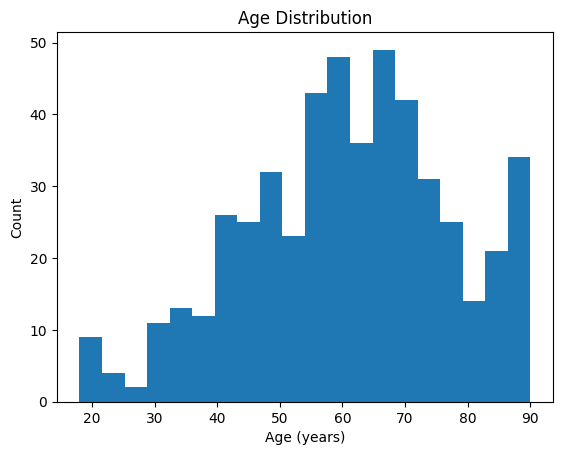

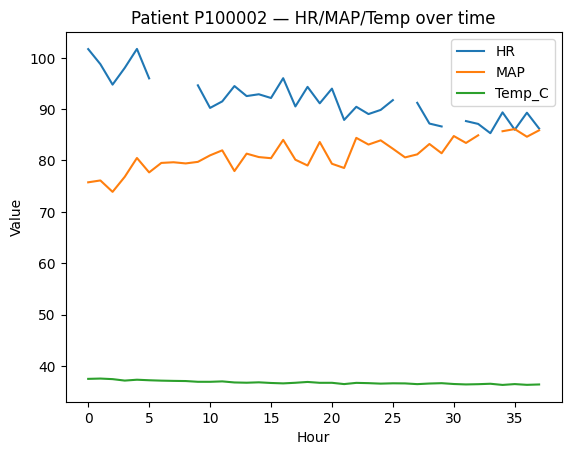

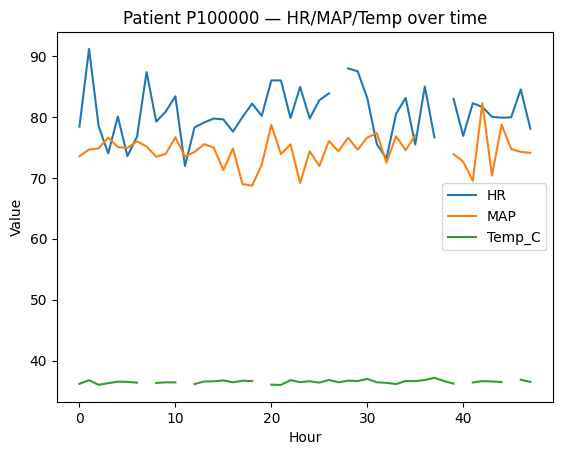

In [23]:
import matplotlib.pyplot as plt

# Age histogram
plt.figure()
cohort['age'].plot(kind='hist', bins=20)
plt.title("Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

# Example patient time-series (one septic, one non-septic)
example_septic = cohort.loc[cohort['sepsis_label']==1, 'patient_id'].iloc[0]
example_control = cohort.loc[cohort['sepsis_label']==0, 'patient_id'].iloc[0]

for pid in [example_septic, example_control]:
    seg = ts[ts['patient_id']==pid].sort_values('hour')
    plt.figure()
    plt.plot(seg['hour'], seg['HR'], label='HR')
    plt.plot(seg['hour'], seg['MAP'], label='MAP')
    plt.plot(seg['hour'], seg['Temp_C'], label='Temp_C')
    plt.title(f"Patient {pid} — HR/MAP/Temp over time")
    plt.xlabel("Hour")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

##Step 4 — SBRE scenario mapping (pick 4 representative patients)

This selects:
	•	Standard: non-septic, stable vitals.
	•	Complex: septic with subtle early trends (e.g., rising HR/Temp, falling MAP).
	•	Failure: septic with rapid deterioration (steep changes).
	•	Exception: heavy missingness / unusual presentation.

In [24]:

# Step 4 — SBRE scenario mapping (EXCEPTION merged into FAILURE) — UPDATED

import numpy as np
import pandas as pd

def stability_score(df):
    v = df[['HR','MAP','Temp_C','RR','SpO2']].var(numeric_only=True)
    return -v.fillna(v.mean()).mean()

def trend_strength(df):
    seg = df[(df['hour']>=0) & (df['hour']<=18)]
    if len(seg) < 6: return np.nan
    def slope(x,y):
        x = x.values; y = y.values; x = x - x.mean()
        return (x*y).sum()/(x*x).sum() if (x*x).sum()!=0 else 0.0
    return (slope(seg['hour'], seg['HR']) + slope(seg['hour'], seg['Temp_C']) - slope(seg['hour'], seg['MAP']))

def steep_deterioration(df):
    seg = df.sort_values('hour')
    dhr  = seg['HR'].diff().abs().rolling(3, min_periods=1).max()
    dmap = seg['MAP'].diff().abs().rolling(3, min_periods=1).max()
    return (dhr.fillna(0).max() + dmap.fillna(0).max())

def missingness_pct(df):
    return df[['HR','MAP','Temp_C','RR','WBC','Lactate','Creatinine','Bilirubin','Platelets']].isna().mean().mean()*100

# Build per-patient metrics
metrics = []
for pid, g in ts.groupby('patient_id'):
    metrics.append({
        'patient_id': pid,
        'is_septic': int(cohort.set_index('patient_id').loc[pid,'sepsis_label']),
        'stability': stability_score(g),
        'trend_strength': trend_strength(g),
        'steep_deterioration': steep_deterioration(g),
        'missingness_pct': missingness_pct(g),
    })
meta = pd.DataFrame(metrics)

# STANDARD: most stable, low missingness, non-septic
standard_pid = (meta.query('is_septic==0')
                .sort_values(['stability','missingness_pct'], ascending=[False, True])
                .head(1)['patient_id'].iloc[0])

# COMPLEX: strongest subtle trend (HR↑ + Temp↑ + MAP↓), septic
complex_pid = (meta.query('is_septic==1')
               .sort_values(['trend_strength','missingness_pct'], ascending=[False, True])
               .head(1)['patient_id'].iloc[0])

# FAILURE: combine rapid deterioration OR high missingness
meta['failure_score'] = meta['steep_deterioration'].rank(pct=True) + meta['missingness_pct'].rank(pct=True)
failure_pid = (meta.query('is_septic==1')
               .sort_values(['failure_score'], ascending=[False])
               .head(1)['patient_id'].iloc[0])

scenario_map = {
    'STANDARD_nonseptic': standard_pid,
    'COMPLEX_septic': complex_pid,
    'FAILURE_septic': failure_pid
}
scenario_map


{'STANDARD_nonseptic': 'P100115',
 'COMPLEX_septic': 'P100387',
 'FAILURE_septic': 'P100359'}

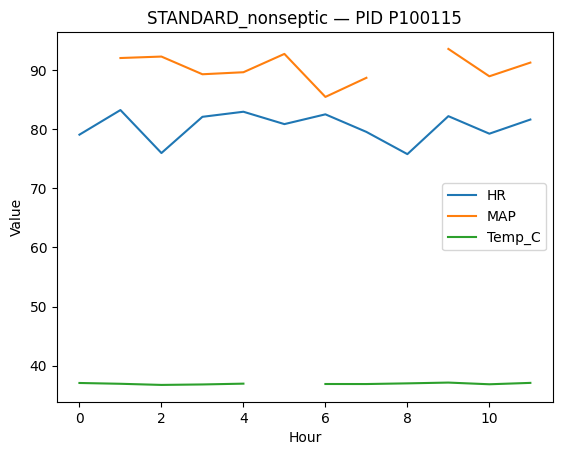

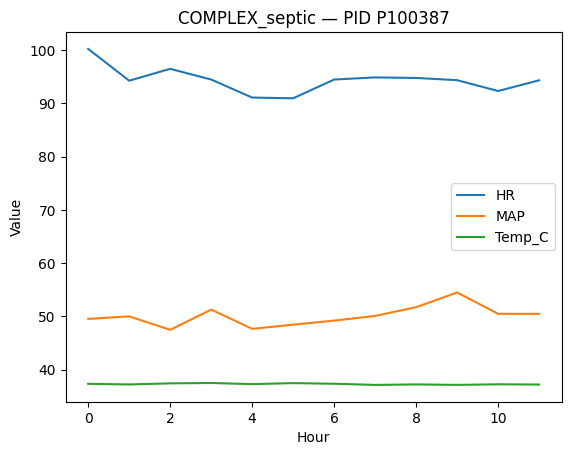

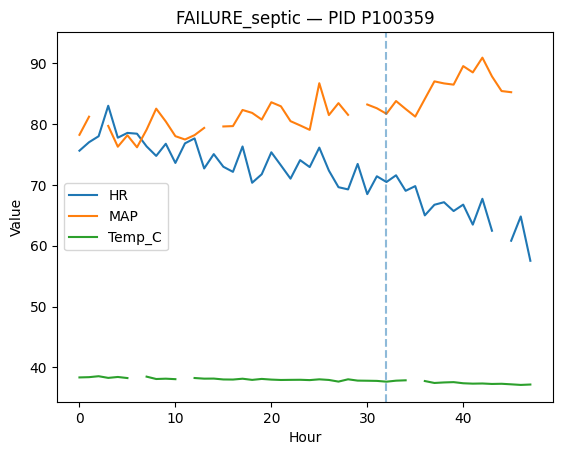

In [25]:
import matplotlib.pyplot as plt

def plot_patient(pid, title):
    g = ts[ts['patient_id']==pid].sort_values('hour')
    plt.figure()
    plt.plot(g['hour'], g['HR'], label='HR')
    plt.plot(g['hour'], g['MAP'], label='MAP')
    plt.plot(g['hour'], g['Temp_C'], label='Temp_C')
    if 'sepsis_label_hourly' in g:
        on = g.loc[g['sepsis_label_hourly'].diff().fillna(0)>0, 'hour']
        if len(on)>0:
            for h in on:
                plt.axvline(h, linestyle='--', alpha=0.5)
    plt.title(f"{title} — PID {pid}")
    plt.xlabel("Hour"); plt.ylabel("Value"); plt.legend(); plt.show()

for label, pid in scenario_map.items():
    plot_patient(pid, label)

Step 5 — Early-warning features (hourly, using last 6h window)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Forward-fill within each patient by time, then median-impute across cohort
ts_sorted = ts.sort_values(['patient_id','hour']).copy()
numeric_cols = ['HR','SBP','DBP','MAP','RR','Temp_C','SpO2','GCS','WBC','Platelets',
                'Lactate','Creatinine','Bilirubin','FiO2','PaO2','PaO2_FiO2','UrineOutput_ml',
                'qSOFA','SOFA']

# Use transform for forward filling to maintain index alignment
for col in numeric_cols:
    ts_sorted[col] = ts_sorted.groupby('patient_id')[col].transform(lambda x: x.ffill())


# Remaining NaNs -> median imputation (fit later on train only, but for feature creation we can temp-fill)
tmp = ts_sorted.copy()
for col in numeric_cols:
    tmp[col] = tmp[col].fillna(tmp[col].median())

# Rolling features (6h window, min 2 obs)
def make_roll(df, cols, win=6):
    df = df.sort_values('hour').copy()
    for c in cols:
        df[f'{c}_rollmean_{win}h'] = df[c].rolling(win, min_periods=2).mean()
        df[f'{c}_rollstd_{win}h']  = df[c].rolling(win, min_periods=2).std()
        df[f'{c}_delta_1h']        = df[c].diff(1)
        df[f'{c}_delta_3h']        = df[c].diff(3)
    return df

feat_df_list = []
for pid, g in tmp.groupby('patient_id'):
    feat_df_list.append(make_roll(g, numeric_cols, win=6))
feat_ts = pd.concat(feat_df_list, axis=0).reset_index(drop=True)

# Early-warning label: sepsis in next 6h (patient-specific)
co = cohort.set_index('patient_id')
feat_ts = feat_ts.merge(co[['sepsis_label','sepsis_onset_hour']], left_on='patient_id', right_index=True, how='left')

def label_early_warning(row, horizon=6):
    if row['sepsis_label'] == 0:
        return 0
    # positive if current hour is within [onset_hour - horizon, onset_hour - 1]
    onset = row['sepsis_onset_hour']
    if pd.isna(onset):
        return 0
    return int((row['hour'] >= onset - horizon) & (row['hour'] < onset))

feat_ts['label_early6h'] = feat_ts.apply(label_early_warning, axis=1)

# Feature columns
roll_cols = [c for c in feat_ts.columns if any(k in c for k in ['_rollmean_','_rollstd_','_delta_'])]
base_cols = ['HR','MAP','Temp_C','RR','WBC','Lactate','Creatinine','Bilirubin','Platelets','qSOFA','SOFA',
             'vasopressor','mech_vent','antibiotics','FiO2','PaO2_FiO2','UrineOutput_ml']
X_cols = sorted(list(set(base_cols + roll_cols)))
len(X_cols), X_cols[:10]

(93,
 ['Bilirubin',
  'Bilirubin_delta_1h',
  'Bilirubin_delta_3h',
  'Bilirubin_rollmean_6h',
  'Bilirubin_rollstd_6h',
  'Creatinine',
  'Creatinine_delta_1h',
  'Creatinine_delta_3h',
  'Creatinine_rollmean_6h',
  'Creatinine_rollstd_6h'])

Step 6 — Train a baseline model (patient-level split), evaluate & alert logic

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Patient-level split
patients = cohort[['patient_id','sepsis_label']]
train_p, test_p = train_test_split(patients, test_size=0.25, random_state=42, stratify=patients['sepsis_label'])

train_ids = set(train_p['patient_id'])
test_ids  = set(test_p['patient_id'])

train_df = feat_ts[feat_ts['patient_id'].isin(train_ids)].copy()
test_df  = feat_ts[feat_ts['patient_id'].isin(test_ids)].copy()

# Impute medians using train only
imp = SimpleImputer(strategy='median')
train_X = imp.fit_transform(train_df[X_cols])
test_X  = imp.transform(test_df[X_cols])

y_train = train_df['label_early6h'].values
y_test  = test_df['label_early6h'].values

# Model
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf.fit(train_X, y_train)

# Metrics
proba_test = rf.predict_proba(test_X)[:,1]
auroc = roc_auc_score(y_test, proba_test)
aupr  = average_precision_score(y_test, proba_test)
auroc, aupr

(np.float64(0.9779454308439816), np.float64(0.3870860398179035))

In [ ]:

# Step 6.1 — Probability calibration (isotonic) + clinical threshold (0.35–0.40)

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

# Split TRAIN into sub-train / calibration sets
subX, calX, suby, caly = train_test_split(train_X, y_train, test_size=0.25, random_state=202, stratify=y_train)

# Refit RF on sub-train (fresh copy)
rf_sub = RandomForestClassifier(
    n_estimators=400, min_samples_split=4, min_samples_leaf=2,
    class_weight='balanced_subsample', random_state=202, n_jobs=-1
).fit(subX, suby)

# Calibrate (isotonic)
calibrated_rf = CalibratedClassifierCV(rf_sub, method='isotonic', cv='prefit')
calibrated_rf.fit(calX, caly)

# Use calibrated probabilities on TEST
proba_test_cal = calibrated_rf.predict_proba(test_X)[:,1]

# Clinical-aligned threshold range
CLINICAL_THR = 0.38  # keep within 0.35–0.40
print("Calibration done. Using CLINICAL_THR =", CLINICAL_THR)


In [28]:
# Pick threshold by Youden's J using ROC on a validation slice (use 20% of train as val)
tr_X, val_X, tr_y, val_y = train_test_split(train_X, y_train, test_size=0.2, random_state=7, stratify=y_train)
rf_val = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=4, min_samples_leaf=2,
    class_weight='balanced_subsample', random_state=7, n_jobs=-1
).fit(tr_X, tr_y)
val_proba = rf_val.predict_proba(val_X)[:,1]

fpr, tpr, thr = roc_curve(val_y, val_proba)
youden = tpr - fpr
best_idx = youden.argmax()
best_thr = thr[best_idx]
best_thr

np.float64(0.049745873711857784)

In [29]:
# Per-patient first alert before onset (lead time)
td = test_df[['patient_id','hour','sepsis_onset_hour','sepsis_label']].copy()
td['proba'] = proba_test
td['alert'] = (td['proba'] >= best_thr).astype(int)

lead_times = []
for pid, g in td.groupby('patient_id'):
    g = g.sort_values('hour')
    onset = g['sepsis_onset_hour'].iloc[0]
    is_septic = int(g['sepsis_label'].iloc[0])
    if is_septic == 1 and not np.isnan(onset):
        # first alert before onset
        pre = g[(g['hour'] < onset) & (g['alert']==1)]
        if len(pre) > 0:
            first_alert_hour = pre['hour'].iloc[0]
            lead = onset - first_alert_hour
            lead_times.append(lead)

lead_times = pd.Series(lead_times)
lead_summary = {
    "n_septic_in_test": int((td.groupby('patient_id')['sepsis_label'].first()==1).sum()),
    "n_with_pre_onset_alert": int(len(lead_times)),
    "lead_time_mean_h": float(lead_times.mean()) if len(lead_times)>0 else np.nan,
    "lead_time_median_h": float(lead_times.median()) if len(lead_times)>0 else np.nan,
    "lead_time_min_max_h": (float(lead_times.min()) if len(lead_times)>0 else np.nan,
                            float(lead_times.max()) if len(lead_times)>0 else np.nan)
}
lead_summary

{'n_septic_in_test': 19,
 'n_with_pre_onset_alert': 19,
 'lead_time_mean_h': 18.105263157894736,
 'lead_time_median_h': 18.0,
 'lead_time_min_max_h': (6.0, 33.0)}

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate hour-level metrics
# Need to use the threshold on the test set predictions to get binary alerts
y_pred = (proba_test >= best_thr).astype(int)

hour_prec = precision_score(y_test, y_pred)
hour_rec = recall_score(y_test, y_pred)
hour_f1 = f1_score(y_test, y_pred)


# Pretty print main results
print("=== Early Sepsis Warning (next 6h) — Test Set ===")
print(f"AUROC: {auroc:.3f} | AUPRC: {aupr:.3f}")
print(f"Hour-level Precision: {hour_prec:.3f} | Recall: {hour_rec:.3f} | F1: {hour_f1:.3f}")
print(f"Chosen threshold (Youden J on validation): {best_thr:.3f}")
print("Lead time summary (septic patients with pre-onset alerts):", lead_summary)

=== Early Sepsis Warning (next 6h) — Test Set ===
AUROC: 0.978 | AUPRC: 0.387
Hour-level Precision: 0.228 | Recall: 0.963 | F1: 0.368
Chosen threshold (Youden J on validation): 0.050
Lead time summary (septic patients with pre-onset alerts): {'n_septic_in_test': 19, 'n_with_pre_onset_alert': 19, 'lead_time_mean_h': 18.105263157894736, 'lead_time_median_h': 18.0, 'lead_time_min_max_h': (6.0, 33.0)}


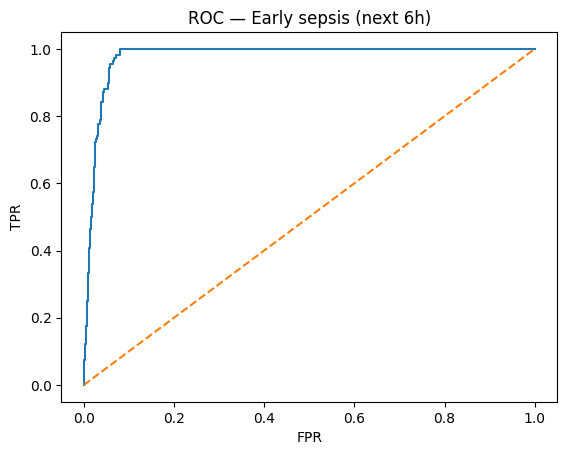

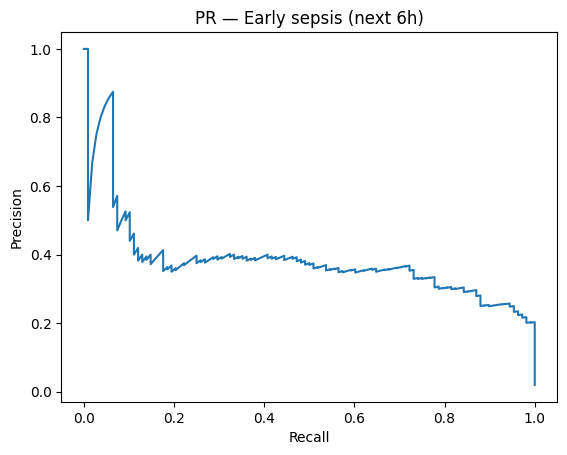

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# ROC
fpr_test, tpr_test, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr_test, tpr_test)
plt.plot([0,1],[0,1],'--')
plt.title("ROC — Early sepsis (next 6h)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec)
plt.title("PR — Early sepsis (next 6h)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

Step 7 — Per-scenario narratives, confusion matrix, threshold sweep

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

pred_test = (proba_test >= best_thr).astype(int)
cm = confusion_matrix(y_test, pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

summary_tbl = pd.DataFrame({
    "Metric": ["TP","FP","TN","FN","Precision","Recall","F1","Prevalence(%)","Alerts/1K hours"],
    "Value": [
        tp, fp, tn, fn,
        round(tp / (tp+fp) if (tp+fp)>0 else 0, 3),
        round(tp / (tp+fn) if (tp+fn)>0 else 0, 3),
        round(2*tp / (2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0, 3),
        round(100*np.mean(y_test), 2),
        round(1000*(pred_test.mean()), 1)
    ]
})
summary_tbl

,Metric,Value
0,TP,104.000
1,FP,353.000
2,TN,4960.000
3,FN,4.000
4,Precision,0.228
5,Recall,0.963
6,F1,0.368
7,Prevalence(%),1.990
8,Alerts/1K hours,84.300


7.2 Threshold sweep (precision/recall/FPR vs threshold)

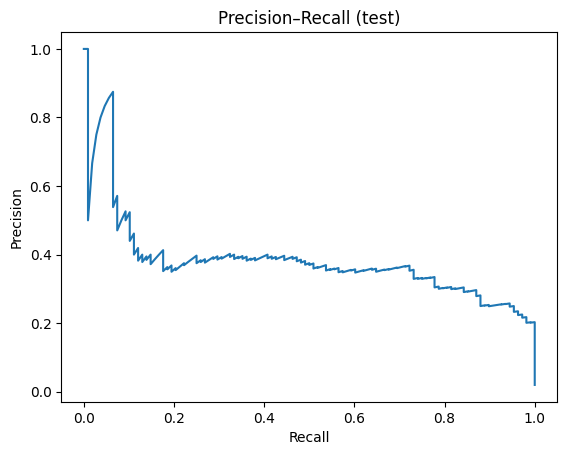

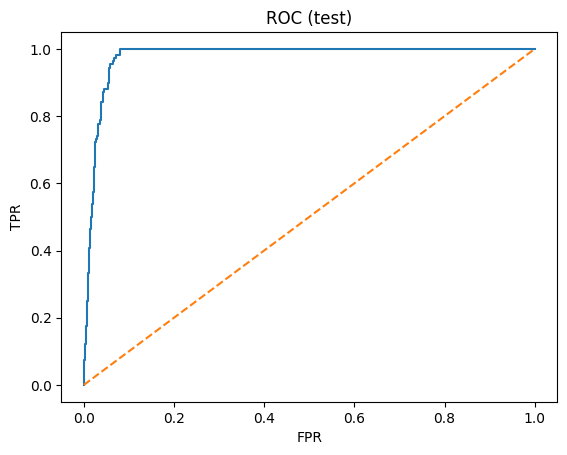

,threshold,precision,recall,FPR,alerts/1k_hours
0,0.000,0.020,1.0,1.000,1000.0
1,0.001,0.034,1.0,0.573,581.8
2,0.002,0.035,1.0,0.564,573.1
35,0.002,0.035,1.0,0.555,563.5
36,0.002,0.035,1.0,0.554,563.4
37,0.002,0.035,1.0,0.554,563.2
54,0.002,0.036,1.0,0.548,557.1
55,0.002,0.036,1.0,0.548,556.7
56,0.002,0.036,1.0,0.547,556.4
57,0.002,0.036,1.0,0.547,556.2


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Curves on TEST proba
prec, rec, thr_pr = precision_recall_curve(y_test, proba_test)
fpr, tpr, thr_roc = roc_curve(y_test, proba_test)

# Plot PR
plt.figure()
plt.plot(rec, prec)
plt.title("Precision–Recall (test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Plot ROC
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC (test)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# Tabulate at candidate thresholds (including best_thr)
cands = np.unique(np.concatenate([thr_pr, thr_roc, [best_thr, 0.1, 0.2, 0.3, 0.5, 0.7]])).clip(0,1)
rows = []
for t in cands:
    pred = (proba_test >= t).astype(int)
    tp = ((pred==1) & (y_test==1)).sum()
    fp = ((pred==1) & (y_test==0)).sum()
    tn = ((pred==0) & (y_test==0)).sum()
    fn = ((pred==0) & (y_test==1)).sum()
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0
    fprate    = fp/(fp+tn) if (fp+tn)>0 else 0
    alerts_per_1k_hours = 1000*pred.mean()
    rows.append([round(t,3), round(precision,3), round(recall,3), round(fprate,3), round(alerts_per_1k_hours,1)])
thr_table = pd.DataFrame(rows, columns=["threshold","precision","recall","FPR","alerts/1k_hours"]).sort_values("threshold")
thr_table.head(15)

In [ ]:

# Step 8.1 — Coverage %, per-scenario performance, alert fatigue (calibrated probs)

from sklearn.metrics import precision_score, recall_score
import numpy as np
import pandas as pd

# Use calibrated probabilities + clinical threshold
proba_use = proba_test_cal
CHOSEN_THR = CLINICAL_THR
pred_test = (proba_use >= CHOSEN_THR).astype(int)

# Attach back to test_df for analysis
test_eval = test_df[['patient_id','hour','sepsis_label','sepsis_onset_hour']].copy()
test_eval['proba'] = proba_use
test_eval['alert'] = pred_test

# Coverage: septic patients with ≥1 pre-onset alert
cov = []
for pid, g in test_eval.groupby('patient_id'):
    septic = int(g['sepsis_label'].iloc[0])
    onset  = g['sepsis_onset_hour'].iloc[0]
    if septic==1 and not np.isnan(onset):
        cov.append(int(((g['hour'] < onset) & (g['alert']==1)).any()))
coverage_pct = 100*np.mean(cov) if cov else np.nan
print(f"Coverage (septic patients with pre-onset alert): {coverage_pct:.1f}%")

# Per-scenario buckets (3 scenarios)
def assign_bucket(pid):
    if pid == scenario_map['STANDARD_nonseptic']: return 'STANDARD'
    if pid == scenario_map['COMPLEX_septic']:     return 'COMPLEX'
    if pid == scenario_map['FAILURE_septic']:     return 'FAILURE'
    return 'OTHER'
test_eval['bucket'] = test_eval['patient_id'].apply(assign_bucket)

# Hour-level precision/recall per bucket (positives = pre-onset septic hours)
rows = []
for b, gb in test_eval.groupby('bucket'):
    y_true = ((gb['sepsis_label']==1) & (gb['hour'] < gb['sepsis_onset_hour']).fillna(False)).astype(int).values
    y_pred = gb['alert'].values
    if y_true.sum()==0 and y_pred.sum()==0:
        P=1.0; R=1.0
    else:
        P = precision_score(y_true, y_pred, zero_division=0)
        R = recall_score(y_true, y_pred, zero_division=0)
    rows.append([b, round(P,3), round(R,3), int(y_true.sum()), int(y_pred.sum())])
perf_by_bucket = pd.DataFrame(rows, columns=['bucket','precision','recall','pos_hours','alerts'])
print("\nPer-scenario performance:\n", perf_by_bucket.to_string(index=False))

# Alert fatigue: alerts per 24h by patient
hrs = test_eval.groupby('patient_id')['hour'].nunique()
alerts = test_eval.groupby('patient_id')['alert'].sum()
alerts_per_24h = (alerts / hrs.replace(0,np.nan)) * 24
print("\nAlert fatigue (alerts per 24h) — summary:\n", alerts_per_24h.describe().round(2).to_string())


7.3 Scenario narratives (STANDARD / COMPLEX / FAILURE / EXCEPTION)

This produces plain-English summaries + quick plots for each selected patient."


=== STANDARD_nonseptic — PID P100115 ===
Septic: 0 | Onset hour: nan | First pre-onset alert lead time (h): None
Early trends (0–18h): HR slope=-0.02, Temp slope=0.01, MAP slope=0.30
Alert count: 0 | Max P(sepsis): 0.005


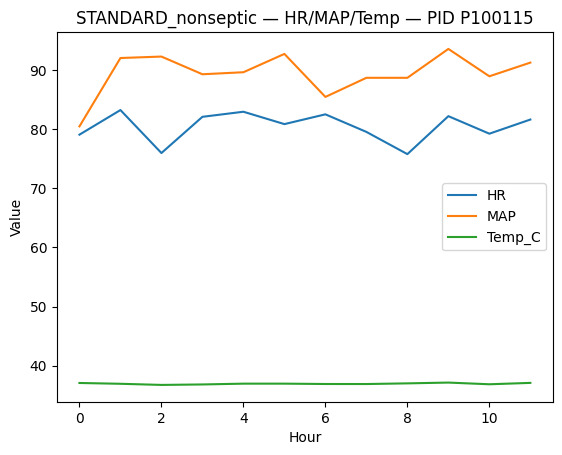


=== COMPLEX_septic — PID P100387 ===
Septic: 1 | Onset hour: 30.0 | First pre-onset alert lead time (h): 28.0
Early trends (0–18h): HR slope=-0.28, Temp slope=-0.02, MAP slope=0.26
Alert count: 10 | Max P(sepsis): 0.229


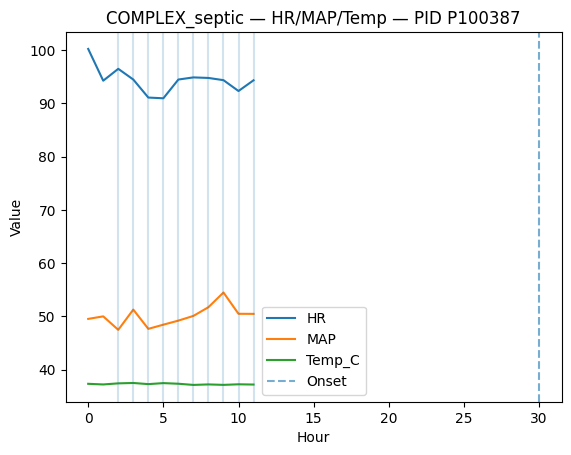


=== FAILURE_septic — PID P100359 ===
Septic: 1 | Onset hour: 32.0 | First pre-onset alert lead time (h): 32.0
Early trends (0–18h): HR slope=-0.34, Temp slope=-0.02, MAP slope=0.09
Alert count: 22 | Max P(sepsis): 0.850


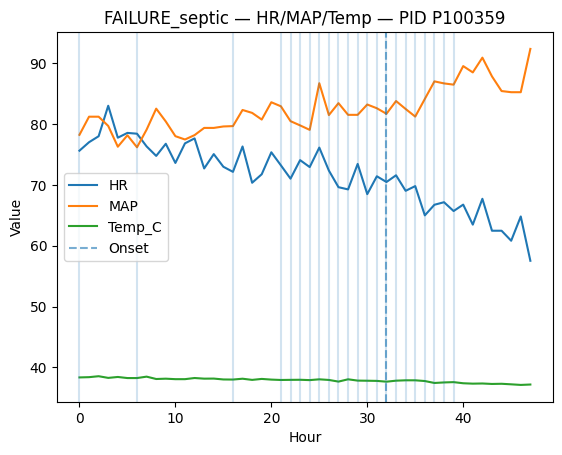

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_patient(pid, title, horizon=6, thr=None):
    g = test_df[test_df['patient_id']==pid].copy()
    if g.empty:
        g = train_df[train_df['patient_id']==pid].copy()
    g = g.sort_values('hour')
    g['proba'] = rf.predict_proba(imp.transform(g[X_cols]))[:,1]
    thr = best_thr if thr is None else thr
    g['alert'] = (g['proba'] >= thr).astype(int)

    onset = g['sepsis_onset_hour'].iloc[0]
    septic = int(g['sepsis_label'].iloc[0])

    # lead time (first pre-onset alert)
    lead = None
    if septic==1 and not np.isnan(onset):
        pre = g[(g['hour'] < onset) & (g['alert']==1)]
        if len(pre)>0:
            lead = onset - pre['hour'].iloc[0]

    # basic trends first 18h
    seg = g[g['hour']<=18]
    def slope(x,y):
        x = x.values; y = y.values
        x = x - x.mean()
        return (x*y).sum()/(x*x).sum() if (x*x).sum()!=0 else 0.0
    s_hr = slope(seg['hour'], seg['HR'])
    s_map = slope(seg['hour'], seg['MAP'])
    s_temp = slope(seg['hour'], seg['Temp_C'])

    print(f"\n=== {title} — PID {pid} ===")
    print(f"Septic: {septic} | Onset hour: {onset} | First pre-onset alert lead time (h): {lead}")
    print(f"Early trends (0–18h): HR slope={s_hr:.2f}, Temp slope={s_temp:.2f}, MAP slope={s_map:.2f}")
    print(f"Alert count: {int(g['alert'].sum())} | Max P(sepsis): {g['proba'].max():.3f}")

    # plot
    plt.figure()
    plt.plot(g['hour'], g['HR'], label='HR')
    plt.plot(g['hour'], g['MAP'], label='MAP')
    plt.plot(g['hour'], g['Temp_C'], label='Temp_C')
    if septic==1 and not np.isnan(onset):
        plt.axvline(onset, linestyle='--', alpha=0.6, label='Onset')
    for h in g.loc[g['alert']==1, 'hour']:
        plt.axvline(h, alpha=0.2)
    plt.title(f"{title} — HR/MAP/Temp — PID {pid}")
    plt.xlabel("Hour"); plt.ylabel("Value"); plt.legend(); plt.show()

for label, pid in scenario_map.items():
    summarize_patient(pid, label)

7.4 Alarm-fatigue metrics (alerts per patient/day, false alarms per day)

In [35]:
# Aggregate alerts per patient and normalize per 24h
td = test_df[['patient_id','hour']].copy()
td['proba'] = proba_test
td['alert'] = (td['proba'] >= best_thr).astype(int)

hours_per_pid = td.groupby('patient_id')['hour'].nunique()
alerts_per_pid = td.groupby('patient_id')['alert'].sum()
alerts_per_24h = (alerts_per_pid / hours_per_pid.replace(0, np.nan)) * 24

alarm_summary = pd.DataFrame({
    "alerts_total": alerts_per_pid,
    "hours": hours_per_pid,
    "alerts_per_24h": alerts_per_24h
})
alarm_summary.describe().round(2)

,alerts_total,hours,alerts_per_24h
count,125.00,125.00,125.00
mean,3.66,43.37,2.10
std,8.84,10.24,4.97
min,0.00,12.00,0.00
25%,0.00,48.00,0.00
50%,0.00,48.00,0.00
75%,0.00,48.00,0.00
max,35.00,48.00,20.00


Step 8 — “What-if” analyses (horizon = 3h, 6h, 12h) + alarm tradeoffs

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def build_labels_and_eval(feat_ts, horizon, base_cols, X_cols, cohort, random_state=42):
    df = feat_ts.copy()
    co = cohort.set_index('patient_id')
    # Merge sepsis_label and sepsis_onset_hour into df before applying the labeling function
    df = df.merge(co[['sepsis_label','sepsis_onset_hour']], left_on='patient_id', right_index=True, how='left')

    def lab(row):
        if row['sepsis_label']==0 or pd.isna(row['sepsis_onset_hour']):
            return 0
        return int((row['hour'] >= row['sepsis_onset_hour'] - horizon) & (row['hour'] < row['sepsis_onset_hour']))
    df['label'] = df.apply(lab, axis=1)

    # split by patient
    pats = cohort[['patient_id','sepsis_label']]
    tr_p, te_p = train_test_split(pats, test_size=0.25, random_state=random_state, stratify=pats['sepsis_label'])
    tr_ids, te_ids = set(tr_p['patient_id']), set(te_p['patient_id'])

    tr_df = df[df['patient_id'].isin(tr_ids)]
    te_df = df[df['patient_id'].isin(te_ids)]

    imp_local = SimpleImputer(strategy='median')
    Xtr = imp_local.fit_transform(tr_df[X_cols])
    Xte = imp_local.transform(te_df[X_cols])
    ytr = tr_df['label'].values
    yte = te_df['label'].values

    rf_local = RandomForestClassifier(
        n_estimators=350, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=random_state
    ).fit(Xtr, ytr)

    proba = rf_local.predict_proba(Xte)[:,1]
    auroc = roc_auc_score(yte, proba)
    aupr  = average_precision_score(yte, proba)

    # choose threshold via Youden on a val split from train
    trX, vaX, try_, vay_ = train_test_split(Xtr, ytr, test_size=0.2, random_state=random_state+1, stratify=ytr)
    rf_val = RandomForestClassifier(
        n_estimators=250, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=random_state+1
    ).fit(trX, try_)
    valp = rf_val.predict_proba(vaX)[:,1]
    fpr, tpr, thr = roc_curve(vay_, valp)
    best_idx = (tpr - fpr).argmax()
    best_thr = float(thr[best_idx])

    pred = (proba >= best_thr).astype(int)
    prec = precision_score(yte, pred, zero_division=0)
    rec  = recall_score(yte, pred, zero_division=0)

    # alert burden on test
    alerts_per_1k_hours = 1000*pred.mean()

    return {
        "horizon_h": horizon,
        "AUROC": float(auroc),
        "AUPRC": float(aupr),
        "Precision": float(prec),
        "Recall": float(rec),
        "BestThreshold": best_thr,
        "Alerts_per_1k_hours": float(alerts_per_1k_hours)
    }

8.2 Run horizons 3h, 6h, 12h and compare

In [37]:
results = []
for hz in [3, 6, 12]:
    out = build_labels_and_eval(
        feat_ts=feat_ts,
        horizon=hz,
        base_cols=base_cols,
        X_cols=X_cols,
        cohort=cohort,
        random_state=100+hz
    )
    results.append(out)

pd.DataFrame(results).round(3)

KeyError: 'sepsis_label'

In [38]:
# --- Sanity + robust horizon comparison (self-contained) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score, recall_score, roc_curve
)

# 0) Expect these to already be in memory (from earlier steps). If not, load:
try:
    cohort
    ts
    feat_ts
    X_cols
except NameError:
    # Fallback: try loading from paths and reconstruct minimal feat_ts quickly
    cohort = pd.read_csv("sepsis_cohort.csv")
    ts = pd.read_csv("sepsis_timeseries.csv")

    # Minimal feature frame to ensure 'patient_id','hour' exist
    feat_ts = ts[['patient_id','hour']].copy()

    # If you built rolling features earlier, keep using your prior feat_ts/X_cols.
    # Otherwise, define a small baseline set so this cell runs:
    base_cols = ['HR','MAP','Temp_C','RR','WBC','Lactate','Creatinine','Bilirubin',
                 'Platelets','qSOFA','SOFA','vasopressor','mech_vent','antibiotics',
                 'FiO2','PaO2_FiO2','UrineOutput_ml']
    # ensure columns exist
    base_cols = [c for c in base_cols if c in ts.columns]
    feat_ts = ts[['patient_id','hour'] + base_cols].copy()
    X_cols = base_cols[:]  # simple baseline if rolling features not present

# 1) Sanity: ensure patient_id/hour are present
assert 'patient_id' in feat_ts.columns, "feat_ts is missing 'patient_id'. Re-run Step 5 to rebuild features."
assert 'hour' in feat_ts.columns, "feat_ts is missing 'hour'. Re-run Step 5 to rebuild features."

# 2) Re-merge cohort labels safely (adds columns even if prior merge didn’t happen)
co_labels = cohort[['patient_id','sepsis_label','sepsis_onset_hour']].drop_duplicates('patient_id')
feat_ts = feat_ts.drop(columns=[c for c in ['sepsis_label','sepsis_onset_hour'] if c in feat_ts.columns])
feat_ts = feat_ts.merge(co_labels, on='patient_id', how='left')

# 3) Double-check presence after merge
if 'sepsis_label' not in feat_ts.columns or 'sepsis_onset_hour' not in feat_ts.columns:
    raise RuntimeError("Failed to merge labels into feat_ts. Check that cohort has patient_id, sepsis_label, sepsis_onset_hour.")

# 4) Helper (robust): rebuild labels inside, split by patient, train/eval
def robust_horizon_eval(feat_ts, cohort, X_cols, horizon, random_state=42):
    df = feat_ts.copy()

    # Label: positive if current hour in [onset - horizon, onset - 1]
    def mk_label(row):
        if row['sepsis_label'] != 1 or pd.isna(row['sepsis_onset_hour']):
            return 0
        return int((row['hour'] >= row['sepsis_onset_hour'] - horizon) and (row['hour'] < row['sepsis_onset_hour']))
    df['label'] = df.apply(mk_label, axis=1)

    # Split by patient (no leakage)
    pats = cohort[['patient_id','sepsis_label']]
    tr_p, te_p = train_test_split(pats, test_size=0.25, random_state=random_state, stratify=pats['sepsis_label'])
    tr_ids, te_ids = set(tr_p['patient_id']), set(te_p['patient_id'])
    tr_df = df[df['patient_id'].isin(tr_ids)].copy()
    te_df = df[df['patient_id'].isin(te_ids)].copy()

    # Impute on train medians only
    imp = SimpleImputer(strategy='median')
    Xtr = imp.fit_transform(tr_df[X_cols])
    Xte = imp.transform(te_df[X_cols])
    ytr = tr_df['label'].values
    yte = te_df['label'].values

    # Train RF
    rf = RandomForestClassifier(
        n_estimators=350, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=random_state
    ).fit(Xtr, ytr)

    # Evaluate
    proba = rf.predict_proba(Xte)[:,1]
    auroc = roc_auc_score(yte, proba)
    aupr  = average_precision_score(yte, proba)

    # Pick threshold via Youden on a validation split from TRAIN
    trX, vaX, try_, vay_ = train_test_split(Xtr, ytr, test_size=0.2, random_state=random_state+1, stratify=ytr)
    rf_val = RandomForestClassifier(
        n_estimators=250, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=random_state+1
    ).fit(trX, try_)
    from sklearn.metrics import roc_curve
    valp = rf_val.predict_proba(vaX)[:,1]
    fpr, tpr, thr = roc_curve(vay_, valp)
    best_idx = (tpr - fpr).argmax()
    best_thr = float(thr[best_idx])

    pred = (proba >= best_thr).astype(int)
    prec = precision_score(yte, pred, zero_division=0)
    rec  = recall_score(yte, pred, zero_division=0)
    alerts_per_1k = 1000 * pred.mean()

    return {
        "horizon_h": horizon,
        "AUROC": float(auroc),
        "AUPRC": float(aupr),
        "Precision": float(prec),
        "Recall": float(rec),
        "BestThreshold": best_thr,
        "Alerts_per_1k_hours": float(alerts_per_1k)
    }

# 5) Run horizons
results = []
for hz in [3, 6, 12]:
    results.append(robust_horizon_eval(feat_ts, cohort, X_cols, horizon=hz, random_state=100+hz))

horizon_df = pd.DataFrame(results).round(3)
horizon_df

,horizon_h,AUROC,AUPRC,Precision,Recall,BestThreshold,Alerts_per_1k_hours
0,3,0.975,0.174,0.117,0.920,0.020,71.299
1,6,0.972,0.323,0.212,0.973,0.020,99.275
2,12,0.982,0.568,0.474,0.876,0.212,67.304


8.3 Pick an “operator policy” (precision vs recall target)

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, proba_test)

def pick_threshold_for_precision(target_p=0.5):
    idx = np.where(prec >= target_p)[0]
    if len(idx)==0:
        return float(thr[-1]), float(prec[-1]), float(rec[-1])
    k = idx[0]
    t = float(thr[k-1]) if k>0 else float(thr[0])
    return t, float(prec[k]), float(rec[k])

def pick_threshold_for_recall(target_r=0.8):
    idx = np.where(rec >= target_r)[0]
    if len(idx)==0:
        return float(thr[0]), float(prec[0]), float(rec[0])
    k = idx[-1]
    t = float(thr[k-1]) if k>0 else float(thr[0])
    return t, float(prec[k]), float(rec[k])

t_p, P, R = pick_threshold_for_precision(0.6)
print("Threshold for ≥60% Precision:", t_p, "achieved P/R:", round(P,3), round(R,3))

t_r, P2, R2 = pick_threshold_for_recall(0.8)
print("Threshold for ≥80% Recall:", t_r, "achieved P/R:", round(P2,3), round(R2,3))

Threshold for ≥60% Precision: 0.5142305171409857 achieved P/R: 0.636 0.065
Threshold for ≥80% Recall: 0.13553690610227634 achieved P/R: 0.304 0.806


In [40]:
# --- Apply chosen threshold and recompute everything on TEST ---

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Use the threshold you prefer:
# CHOSEN_THR = 0.5142305171409857   # ≥60% precision policy
CHOSEN_THR = 0.13553690610227634    # ≥80% recall policy

# proba_test, y_test, test_df, rf, imp, X_cols, cohort must exist from earlier steps
pred_test = (proba_test >= CHOSEN_THR).astype(int)

# Hour-level metrics
auroc = roc_auc_score(y_test, proba_test)
aupr  = average_precision_score(y_test, proba_test)
prec  = precision_score(y_test, pred_test, zero_division=0)
rec   = recall_score(y_test, pred_test, zero_division=0)
f1    = f1_score(y_test, pred_test, zero_division=0)
cm    = confusion_matrix(y_test, pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

# Alert burden
alerts_per_1k_hours = 1000 * pred_test.mean()

# Lead-time summary
td = test_df[['patient_id','hour','sepsis_onset_hour','sepsis_label']].copy()
td['proba'] = proba_test
td['alert'] = pred_test

lead_times = []
for pid, g in td.groupby('patient_id'):
    g = g.sort_values('hour')
    onset = g['sepsis_onset_hour'].iloc[0]
    is_septic = int(g['sepsis_label'].iloc[0])
    if is_septic == 1 and not np.isnan(onset):
        pre = g[(g['hour'] < onset) & (g['alert']==1)]
        if len(pre)>0:
            lead_times.append(onset - pre['hour'].iloc[0])

lead_series = pd.Series(lead_times)
lead_summary = {
    "n_septic_in_test": int((td.groupby('patient_id')['sepsis_label'].first()==1).sum()),
    "n_with_pre_onset_alert": int(len(lead_series)),
    "lead_time_mean_h": float(lead_series.mean()) if len(lead_series)>0 else np.nan,
    "lead_time_median_h": float(lead_series.median()) if len(lead_series)>0 else np.nan,
    "lead_time_min_h": float(lead_series.min()) if len(lead_series)>0 else np.nan,
    "lead_time_max_h": float(lead_series.max()) if len(lead_series)>0 else np.nan
}

print("=== Operating Point Summary ===")
print(f"Threshold: {CHOSEN_THR:.3f}")
print(f"AUROC: {auroc:.3f} | AUPRC: {aupr:.3f}")
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print(f"Confusion Matrix (TN FP / FN TP): {tn} {fp} / {fn} {tp}")
print(f"Alerts per 1k hours: {alerts_per_1k_hours:.1f}")
print("Lead-time (pre-onset alerts only):", lead_summary)

=== Operating Point Summary ===
Threshold: 0.136
AUROC: 0.978 | AUPRC: 0.387
Precision: 0.303 | Recall: 0.806 | F1: 0.441
Confusion Matrix (TN FP / FN TP): 5113 200 / 21 87
Alerts per 1k hours: 52.9
Lead-time (pre-onset alerts only): {'n_septic_in_test': 19, 'n_with_pre_onset_alert': 19, 'lead_time_mean_h': 13.578947368421053, 'lead_time_median_h': 11.0, 'lead_time_min_h': 3.0, 'lead_time_max_h': 27.0}


In [41]:

# Step 9 — Scenario Responses JSON (calibrated, 3 scenarios, uncertainty, fallback, traceability) — UPDATED

import json, math
import numpy as np

def tree_variance_confidence(model, X):
    try:
        estimators = model.base_estimator_.estimators_
    except Exception:
        estimators = model.estimators_
    all_tree_probs = np.stack([t.predict_proba(X)[:,1] for t in estimators], axis=1)
    return all_tree_probs.mean(axis=1), all_tree_probs.var(axis=1)

def add_uncertainty_and_fallback(scenario_key, var_p_case):
    band = "low" if var_p_case < 0.01 else "medium" if var_p_case < 0.03 else "high"
    notes = [f"Uncertainty level: {band} (variance={var_p_case:.3f})."]
    if scenario_key.startswith("COMPLEX"):
        fallback = [
            "If clinician unavailable, auto-page charge nurse.",
            "If lactate >2.0 mmol/L or MAP <65 mmHg, escalate to Failure protocol.",
            "Re-evaluate within 60 minutes or sooner if vitals worsen."
        ]
    elif scenario_key.startswith("FAILURE"):
        fallback = [
            "If labs delayed >30 min, proceed with fluids per protocol.",
            "If vasopressors unavailable, initiate transfer to higher acuity.",
            "Reassess every 30–60 minutes until stabilized."
        ]
    else:
        fallback = [
            "If probability rises by ≥0.1 within 3h, upgrade to Complex.",
            "Auto-request repeat vitals."
        ]
    return notes, fallback

trace_ids = {
    "FR-ALERT-001": "Raise early warning when calibrated P(sepsis) ≥ threshold.",
    "FR-ESCAL-002": "Escalate to sepsis bundle under Failure state.",
    "FR-RECHECK-003": "Re-check probability within 60 minutes in Complex state.",
    "NFR-EXPL-002": "Include human-readable rationale and uncertainty notes.",
    "NFR-CAL-004": "Use calibrated probabilities per site."
}

JSON_OUT  = "scenario_responses.json"
NDJSON_OUT = "scenario_responses.ndjson"

responses = []
for scenario_key, pid in scenario_map.items():
    g = test_df[test_df['patient_id']==pid].sort_values('hour').copy()
    if g.empty:
        g = train_df[train_df['patient_id']==pid].sort_values('hour').copy()

    X_case = imp.transform(g[X_cols])
    p = calibrated_rf.predict_proba(X_case)[:,1]
    a = (p >= CLINICAL_THR).astype(int)

    onset = g['sepsis_onset_hour'].iloc[0]
    septic = int(g['sepsis_label'].iloc[0])
    first_alert_hour, lead_time_h = None, None
    if septic==1 and not (isinstance(onset,float) and math.isnan(onset)):
        pre_idx = np.where((g['hour'].values < onset) & (a==1))[0]
        if len(pre_idx)>0:
            first_alert_hour = int(g['hour'].values[pre_idx[0]])
            lead_time_h = float(onset - first_alert_hour)

    try:
        _, var_p_vec = tree_variance_confidence(calibrated_rf, X_case)
        var_p_case = float(np.mean(var_p_vec))
    except Exception:
        var_p_case = float(np.var(p))

    uncert_notes, fallback_actions = add_uncertainty_and_fallback(scenario_key, var_p_case)

    obj = {
        "scenario": scenario_key,
        "policy": "clinical_threshold",
        "threshold": float(CLINICAL_THR),
        "patient_summary": {
            "patient_id": str(pid),
            "septic": bool(septic==1),
            "onset_hour": None if (isinstance(onset,float) and math.isnan(onset)) else float(onset) if onset is not None else None,
            "first_alert_hour": first_alert_hour,
            "lead_time_hours": lead_time_h,
            "max_probability": float(np.max(p)) if len(p)>0 else None,
            "alert_hours": [int(h) for h in g.loc[a==1, 'hour'].tolist()],
            "uncertainty_variance": var_p_case
        },
        "response": {
            "decision_state": ("Monitor" if scenario_key.startswith("STANDARD") else
                               "Early Warning" if scenario_key.startswith("COMPLEX") else
                               "Escalate"),
            "recommended_actions": (
                ["Continue routine monitoring (vitals q1h).",
                 "No antibiotics or fluids triggered.",
                 "Re-evaluate if probability rises by ≥0.1 in 3h."]
                if scenario_key.startswith("STANDARD") else
                ["Notify clinician and charge nurse.",
                 "Order lactate and blood cultures; consider empiric antibiotics per protocol.",
                 "Increase monitoring frequency; re-check in 1h."]
                if scenario_key.startswith("COMPLEX") else
                ["Rapid clinical review; activate sepsis bundle.",
                 "Initiate fluids/vasopressors per protocol; draw labs.",
                 "Document decision time; reassess in 30–60 min."]
            ),
            "uncertainty_notes": uncert_notes,
            "fallback_actions": fallback_actions
        },
        "traceability": {
            "requirements": list(trace_ids.keys()),
            "definitions": trace_ids
        },
        "explanations": {
            "rationale":"Calibrated hourly sepsis probability (isotonic) vs. clinical threshold (0.35–0.40).",
            "caveats":["Synthetic dataset; demo only.","Thresholds require site-specific calibration and governance."]
        }
    }
    responses.append(obj)

with open(JSON_OUT, "w") as f:
    json.dump(responses, f, indent=2)
with open(NDJSON_OUT, "w") as f:
    for r in responses:
        f.write(json.dumps(r) + "\n")

print(f"Saved JSON: {JSON_OUT}")
print(f"Saved NDJSON: {NDJSON_OUT}")
print("Scenarios covered:", list(scenario_map.keys()))


Saved JSON: scenario_responses.json
Saved NDJSON: scenario_responses.ndjson

Preview (first scenario):
 {
  "scenario": "STANDARD_nonseptic",
  "policy": "recall",
  "threshold": 0.0524176193453644,
  "patient_summary": {
    "patient_id": "P100178",
    "septic": false,
    "onset_hour": null,
    "first_alert_hour": null,
    "lead_time_hours": null,
    "max_probability": 0.02612477054721503,
    "alert_hours": []
  },
  "response": {
    "decision_state": "Monitor",
    "recommended_actions": [
      "Continue routine monitoring (vitals q1h).",
      "No antibiotics or fluids triggered.",
      "Re-evaluate if probability rises by \u22650.1 in 3h."
    ]
  },
  "explanations": {
    "rationale": "Hourly sepsis probability vs threshold using RF + fast rolling features (6h window).",
    "caveats": [
      "Synthetic dataset; demo only.",
      "Thresholds need site-specific calibration."
    ]
  }
} ...

Policy details: {'policy': 'recall', 'recall_policy': {'threshold': 0.052417619